# Import Functions

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from pathlib import Path
import numpy as np
#import hyperspy.api as hs
import matplotlib.pyplot as plt
#from dask_ml.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models,transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import matplotlib.pyplot as plt 
from torch.autograd import Function
from collections import OrderedDict
import torch.nn as nn
import math
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
import pickle
import torch.autograd as autograd
import matplotlib.gridspec as gridspec
import os
import h5py
# from torchsummary import summary
# import pytorch_model_summary as pms
from tqdm import tqdm
#import torch.tensor as tensor
from scipy import ndimage
import matplotlib.pyplot as plt
import skimage
from skimage.feature import peak_local_max
from skimage import data, img_as_float,feature
from skimage import io
import cv2

In [2]:
import matplotlib.pylab as pylab

params = {'axes.titlesize':20,
          'xtick.direction': 'in' ,
          'ytick.direction' : 'in',
          'xtick.top' : True,
          'ytick.right' : True,
          'ytick.labelsize':16,
          'xtick.labelsize':16
         }

pylab.rcParams.update(params)

In [3]:
torch.__version__

'2.2.0+cu121'

In [4]:
#import atomai as aoi
#import kornia as K
import cv2
import scipy
import argparse
import skimage
from skimage.util import random_noise
from skimage import feature
import glob
from scipy import ndimage
import scipy as sp
import random

In [5]:
import warnings
warnings.filterwarnings('ignore') 

In [7]:
from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
# from ray import tune
# from ray.tune import CLIReporter
# from ray.tune.schedulers import ASHAScheduler
# from ray.air import session

In [8]:
# import sys
# !{sys.executable} -m pip install -U "ray[tune]"

In [9]:
torch.cuda.device_count()

1

# Build two type of mask for two training process

## Set the mask function

In [10]:
def mask_function(img,radius=7,center_coordinates=(100,100)):
    image = np.copy(img.squeeze())
    thickness = -1
    color = 100
    image_2 = cv2.circle(image, center_coordinates, radius,color, thickness)
    image_2 = np.array(image_2)
    mask = (image_2==100)
    mask = np.array(mask)

    return mask

## Set a 200x200 image

In [11]:
mean_ = np.zeros([200,200])

## Build Mask 1

In [13]:
mask_0 = mask_function(mean_,radius=20,center_coordinates=(100,100))
mask_1 = mask_function(mean_,radius=85,center_coordinates=(100,100))
# mask_2 = mask_function(mean_,radius=12,center_coordinates=(163,113))
# mask_3 = mask_function(mean_,radius=12,center_coordinates=(144,51))
# mask_4 = mask_function(mean_,radius=12,center_coordinates=(80,38))
# mask_5 = mask_function(mean_,radius=12,center_coordinates=(37,86))
# Combine all components together
mask_up_1 = ~mask_0*mask_1

In [14]:
new_mask_1 = torch.tensor(mask_up_1)
mask_list_1 = [new_mask_1]

## Build Mask 2

### define the original 6 dots mask framework 

In [63]:
mask_0 = mask_function(mean_,radius=11,center_coordinates=(99,162))
mask_1 = mask_function(mean_,radius=11,center_coordinates=(154,130))
mask_2 = mask_function(mean_,radius=11,center_coordinates=(154,68))
mask_3 = mask_function(mean_,radius=11,center_coordinates=(99,36))
mask_4 = mask_function(mean_,radius=11,center_coordinates=(45,68))
mask_5 = mask_function(mean_,radius=11,center_coordinates=(45,130))
# Combine all components together

mask_up_2 = mask_0+mask_1+mask_2+mask_3+mask_4+mask_5

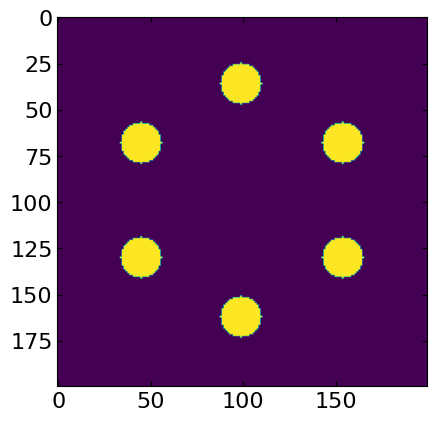

In [64]:
plt.imshow(mask_up_2)

In [65]:
mask_0 = torch.tensor(mask_0)
mask_1 = torch.tensor(mask_1)
mask_2 = torch.tensor(mask_2)
mask_3 = torch.tensor(mask_3)
mask_4 = torch.tensor(mask_4)
mask_5 = torch.tensor(mask_5)

In [66]:
mask_list_2 = [mask_0,mask_1,mask_2,mask_3,mask_4,mask_5]
new_mask_2 = torch.tensor(mask_up_2)

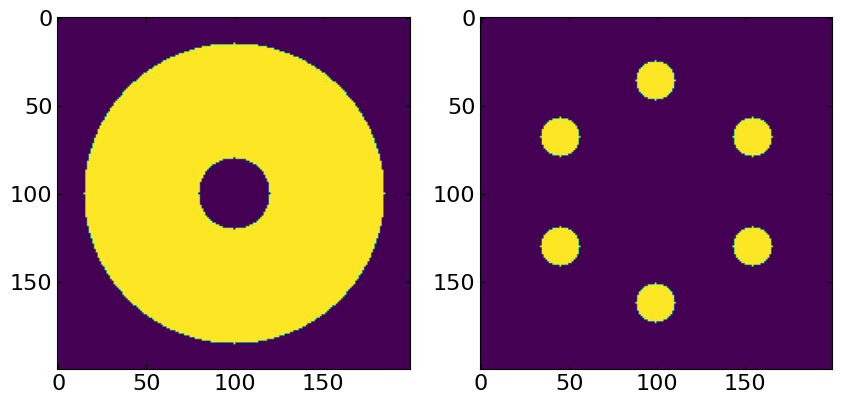

In [67]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(mask_up_1)
ax[1].imshow(mask_up_2)

# Loading Data

In [68]:
# Set data direction
data_dir = os.path.abspath("./polycrystal_output4D.mat")

## Load data function 1 for first training process

## Load data function 2 for second training process

In [69]:
def load_data_4_process2(data_dir, pre_rot, w_bg=0.60):
    
    '''
    
        data_dir: path of the dataset
        label_index: path of the pretrained rotation 
    
    '''
    
    f = h5py.File(data_dir,'r')
    op4d = f['output4D']
    op4d = op4d[:,:,28:228,28:228]
    op4d = np.transpose(op4d, (1, 0, 3, 2))
    op4d = op4d.reshape(-1,200,200)
    f.close()
    
    if w_bg == 0:
        
        noisy_data = op4d*1e5/4
    
    else:
    
        noisy_data = np.zeros([65536,200,200])
        im=np.zeros([200,200])
        counts_per_probe = 1e5
        for i in tqdm(range(65536),leave=True,total=65536):
            test_img = np.copy(op4d[i])
            qx = np.fft.fftfreq( im.shape[0], d = 1)
            qy = np.fft.fftfreq( im.shape[1], d = 1)
            qya, qxa = np.meshgrid(qy, qx)
            qxa = np.fft.fftshift(qxa)
            qya = np.fft.fftshift(qya) 
            qra2 = qxa**2 + qya**2
            im_bg = 1./( 1 + qra2 / 1e-2**2 )
            im_bg = im_bg / np.sum(im_bg) 
            int_comb = test_img * (1 - w_bg) + im_bg * w_bg 
            int_noisy = np.random.poisson(int_comb * counts_per_probe) / counts_per_probe
            int_noisy = int_noisy*1e5/4
            noisy_data[i] = int_noisy
        
    del op4d
    
    noisy_data = noisy_data.reshape(-1,1,200,200)
    angle = np.mod(np.arctan2(
        pre_rot[:,1].reshape(256,256),
        pre_rot[:,0].reshape(256,256)),np.pi/3).reshape(-1)
    
    
    # combine the data and label for test
    whole_data_with_rotation = []
    for i in tqdm(range(noisy_data.shape[0]),leave=True, total=noisy_data.shape[0]):
        whole_data_with_rotation.append([noisy_data[i], angle[i]])
        
    return whole_data_with_rotation

# Autoencoder

In [70]:
def crop_small_square(center_coordinates,radius=50):
    
    center_coordinates = torch.round(center_coordinates)
    
    x_coor = (int(center_coordinates[0]-radius),int(center_coordinates[0]+radius))
    
    y_coor = (int(center_coordinates[1]-radius),int(center_coordinates[1]+radius))

    return x_coor,y_coor

In [71]:
def center_of_mass(img,mask,coef=1.5):
    
    cor_x,cor_y = torch.where(mask!=0)
    mean_mass = torch.mean(img[mask])
    mass = F.relu(img[mask]-coef*mean_mass)
    img_after = torch.clone(img)
    img_after[mask] = mass
    
    sum_mass = torch.sum(mass)
    
    if sum_mass == 0:
        weighted_x = torch.sum(cor_x)/len(cor_x)
        weighted_y = torch.sum(cor_y)/len(cor_y)
    else:
        weighted_x = torch.sum(cor_x*mass)/sum_mass
    
        weighted_y = torch.sum(cor_y*mass)/sum_mass
#    plt.figure()
#    plt.imshow(img_after.detach().numpy(),clim=[0,1])
#    plt.figure()
#    plt.plot(weighted_y,weighted_x,'r.')
    return weighted_x,weighted_y

In [72]:
# image: batch input with affine transformation
# mask: the mask added on the diffraction partten
# batch_size: batch of the image
# theta: the batch affine transformation parameter
def revise_size_on_affine_gpu(image, 
                              mask_list, 
                              batch_size, 
                              theta,
                              device,
                              adj_para=None,
                              radius=12,
                              coef=2,
                              pare_reverse=False):
    
#    img0 = np.zeros([image.shape[-1],image.shape[-1]])
    # Add another mask dealing with the diffraction pattern only
    np_img = np.zeros([radius*2,radius*2])
    dot_size = int(4*image.shape[-1]/200)
    small_square_mask = mask_function(np_img,radius=dot_size,center_coordinates=(radius,radius))
    small_square_mask = torch.tensor(small_square_mask,dtype=torch.bool).to(device)

    img = torch.clone(image).to(device)
#    print(img.shape)
    identity = torch.tensor([0,0,1],dtype= torch.float).reshape(1,1,3).repeat(batch_size,1,1).to(device)
    new_theta = torch.cat((theta,identity),axis=1).to(device)
    inver_theta = torch.linalg.inv(new_theta)[:,0:2].to(device)
#    print(theta.shape)
##    print(inver_theta.shape)
#    print('....')
    for j, mask in enumerate(mask_list):
        if mask.shape[0]!= batch_size:
            mask_ = mask.squeeze().unsqueeze(0).unsqueeze(1).repeat(batch_size,1,1,1).to(device)
        else:
            mask_ = mask.reshape(batch_size,1,mask.shape[-2],mask.shape[-1]).to(device)
        
#        print(mask_.shape)
#        mask_ = torch.tensor(mask,dtype=torch.float,requires_grad=True).squeeze().unsqueeze(0).unsqueeze(1).repeat(batch_size,1,1,1)  
#         grid = F.affine_grid(theta, mask_.size()) 
#         mask_apply_affine = F.grid_sample(mask_, grid)
#         mask_apply_affine = torch.tensor(mask_apply_affine,dtype=torch.bool)

        new_image = image*mask_.to(device)
#        print(new_image.shape)
#        new_image = new_image.detach().numpy()
        for i in range(batch_size):
    #        print(new_image[i].shape)
            center_x,center_y = center_of_mass(new_image[i].squeeze(),mask_[i].squeeze(),coef)
        
            center = torch.tensor([center_x,center_y]).to(device)
 #           print(center)
            x_coor,y_coor = crop_small_square(center_coordinates=center.clone(),radius = radius)
            
            
            #crop small square on image after affine transformation

 
         
            small_image = img[i].squeeze()[x_coor[0]:x_coor[1],y_coor[0]:y_coor[1]].unsqueeze(0).unsqueeze(1).clone().to(device)
            re_grid = F.affine_grid(inver_theta[i].unsqueeze(0).to(device), small_image.size()).to(device) 
            
            if adj_para == None:
                
                re_aff_small_image = F.grid_sample(small_image, re_grid, mode = 'bicubic')
                img[i,:,x_coor[0]:x_coor[1],y_coor[0]:y_coor[1]] = re_aff_small_image.squeeze()
                
            else:
                
                
                small_image_copy = torch.clone(small_image.squeeze()).to(device)
    #             print(small_image_copy.shape)
    #             print(small_square_mask.shape)
    # Use the same parameter to fit all the diffraction patterns in mask reigon 
                if pare_reverse:
                    small_image_copy[small_square_mask]/=adj_para[i]
                else:
                    small_image_copy[small_square_mask]*=adj_para[i]
                    
                small_image_copy = small_image_copy.unsqueeze(0).unsqueeze(1)


                re_aff_small_image = F.grid_sample(small_image_copy, re_grid, mode = 'bicubic')
                img[i,:,x_coor[0]:x_coor[1],y_coor[0]:y_coor[1]] = re_aff_small_image.squeeze()
            
    return img

In [73]:
class conv_block(nn.Module):
    def __init__(self,t_size,n_step):
        super(conv_block,self).__init__()
        self.cov1d_1 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov1d_2 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov1d_3 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.norm_3 = nn.LayerNorm(n_step)
        self.relu_1 = nn.ReLU()
        self.relu_2 = nn.ReLU()
        self.relu_3 = nn.ReLU()
#         self.relu_1 = nn.Tanh()
#         self.relu_2 = nn.Tanh()
#         self.relu_3 = nn.Tanh()
        #self.drop = nn.Dropout(p=0.2)
        
    def forward(self,x):
        x_input = x
        out = self.cov1d_1(x)
        out = self.relu_1(out)
        out = self.cov1d_2(out)
        out = self.relu_2(out)
        out = self.cov1d_3(out)
        out = self.norm_3(out)
        out = self.relu_3(out)
        #out = self.drop(out)
        out = out.add(x_input)
        
        return out

In [74]:
class identity_block(nn.Module):
    def __init__(self,t_size,n_step):
        super(identity_block,self).__init__()
        self.cov1d_1 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.norm_1 = nn.LayerNorm(n_step)
        #self.drop = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
#        self.relu = nn.Tanh()
        
    def forward(self,x):
        x_input = x
        out = self.cov1d_1(x)
        out = self.norm_1(out)
        out = self.relu(out)
        #output = self.drop(x)
        
        return out

# Rules to use the model architecture 
### Mask should be included since we use affine transformation function, so the "num_mask" should never be "None"
### The format of mask should be tensor list of the mask, so the fixed_mask should be the list of tenosr 

In [75]:
# narrow the range of the adjust parameter for the mask region, since it is not the noise free dataset,
# this will increase the background noise's influence to the MSE loss
# 
class Encoder(nn.Module):
    def __init__(self,original_step_size,pool_list,embedding_size,conv_size,device,
                 num_basis=2,fixed_mask=None, num_mask=1, interpolate = False, up_size=800):
        super(Encoder,self).__init__()
        
        self.device = device
        blocks = []
        self.input_size_0 = original_step_size[0]
        self.input_size_1 = original_step_size[1]
        number_of_blocks = len(pool_list)
        blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(nn.MaxPool2d(pool_list[0], stride=pool_list[0]))
        for i in range(1,number_of_blocks):
            original_step_size = [original_step_size[0]//pool_list[i-1],original_step_size[1]//pool_list[i-1]]
            blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(nn.MaxPool2d(pool_list[i], stride=pool_list[i])) 
            
        self.block_layer = nn.ModuleList(blocks)
        self.layers=len(blocks)
        original_step_size = [original_step_size[0]//pool_list[-1],original_step_size[1]//pool_list[-1]]
        
        input_size = original_step_size[0]*original_step_size[1]
        self.cov2d = nn.Conv2d(1,conv_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov2d_1 = nn.Conv2d(conv_size,1,3,stride=1,padding=1,padding_mode = 'zeros')
        self.relu_1 = nn.ReLU()
        self.relu_2 = nn.ReLU()
        self.tanh = nn.Tanh()
        self.before = nn.Linear(input_size,20)
        self.embedding_size = embedding_size
        self.mask_size = num_mask
        
        self.interpolate = interpolate
        self.up_size = up_size
        
        if fixed_mask != None:
        # Set the mask_ to upscale mask if the interpolate set True
            if self.interpolate:
                mask_with_inp = []
                for mask_ in fixed_mask:
                    temp_mask = torch.tensor(mask_.reshape(1,1,self.input_size_0,self.input_size_1),dtype=torch.float)
                    temp_mask = F.interpolate(temp_mask, size=(self.up_size,self.up_size),mode = 'bicubic')
                    temp_mask[temp_mask<0.5]=0
                    temp_mask[temp_mask>=0.5]=1
                    temp_mask = torch.tensor(temp_mask.squeeze(),dtype=torch.bool)
                    mask_with_inp.append(temp_mask)
                    
                self.mask = mask_with_inp
                
            else:
                
                self.mask = fixed_mask
        else:
            self.mask = None
            
        if num_mask == None:
            self.dense = nn.Linear(20+num_basis,self.embedding_size)
        else:
        # Set the all the adj parameter to be the same
            self.dense = nn.Linear(20+num_basis,self.embedding_size+1)
        
        self.for_k = nn.Linear(20,num_basis)
        self.norm = nn.LayerNorm(num_basis)
        self.softmax = nn.Softmax()
        self.num_k_sparse=1
        
    def ktop(self,x):
        kout = self.for_k(x)
        kout = self.norm(kout)
        kout = self.softmax(kout)
        k_no = kout.clone()

        k = self.num_k_sparse
        with torch.no_grad():
            if k <= kout.shape[1]:
                for raw in k_no:
                    indices = torch.topk(raw, k)[1].to(self.device)
                    mask = torch.ones(raw.shape, dtype=bool).to(self.device)
                    mask[indices] = False
                    raw[mask] = 0
                    raw[~mask] = 1
        return k_no
    
    

    def find_type(self):
       
        return self.emoji
    
    def find_mask(self):
       
        return self.mask_size
    
    def rotate_mask(self):
        
        return self.mask
    
    def check_inp(self):
        
        return self.interpolate
    
    def check_upsize(self):
        
        return self.up_size
    
    def forward(self,x,rotate_value = None):

        out = x.view(-1,1,self.input_size_0,self.input_size_1)
        out = self.cov2d(out)
        for i in range(self.layers):
            out = self.block_layer[i](out)
        out = self.cov2d_1(out)
        out = torch.flatten(out,start_dim=1)
        kout = self.before(out) 
        
        k_out = self.ktop(kout)
        out = torch.cat((kout,k_out),dim=1).to(self.device)
        out = self.dense(out)
        scale_1 = 0.05*nn.Tanh()(out[:,0])+1
        scale_2 = 0.05*nn.Tanh()(out[:,1])+1
        
        if rotate_value!=None:
            
            # use large mask no need to limit to too small range
            
            rotate = rotate_value.reshape(out[:,2].shape) + 0.1*nn.Tanh()(out[:,2])
            
        else:
            
            rotate = nn.ReLU()(out[:,2])
        
        shear_1 = 0.1*nn.Tanh()(out[:,3])
#        shear_2 = 0.1*nn.Tanh()(out[:,4])
#        print(rotate)
        a_1 = torch.cos(rotate)
#        a_2 = -torch.sin(selection)
        a_2 = torch.sin(rotate)    
        a_4 = torch.ones(rotate.shape).to(self.device)
        a_5 = rotate*0

        
        # combine shear and strain together
        c1 = torch.stack((scale_1,shear_1), dim=1).squeeze()
        c2 = torch.stack((shear_1,scale_2), dim=1).squeeze()
        c3 = torch.stack((a_5,a_5), dim=1).squeeze()
        scaler_shear = torch.stack((c1, c2, c3), dim=2) 

        # Add the rotation after the shear and strain
        b1 = torch.stack((a_1,a_2), dim=1).squeeze()
        b2 = torch.stack((-a_2,a_1), dim=1).squeeze()
        b3 = torch.stack((a_5,a_5), dim=1).squeeze()
        rotation = torch.stack((b1, b2, b3), dim=2)
        
        if self.interpolate == False:
        
            grid_1 = F.affine_grid(scaler_shear.to(self.device), x.size()).to(self.device)
            out_sc_sh = F.grid_sample(x, grid_1)

            grid_2 = F.affine_grid(rotation.to(self.device), x.size()).to(self.device)
            output = F.grid_sample(out_sc_sh, grid_2)
            
        
        else:
            
            x_inp = x.view(-1,1,self.input_size_0,self.input_size_1)
            
            x_inp = F.interpolate(x_inp, size=(self.up_size,self.up_size),mode = 'bicubic')
            
            grid_1 = F.affine_grid(scaler_shear.to(self.device), x_inp.size()).to(self.device)
            out_sc_sh = F.grid_sample(x_inp, grid_1, mode = 'bicubic')

            grid_2 = F.affine_grid(rotation.to(self.device), x_inp.size()).to(self.device)
            output = F.grid_sample(out_sc_sh, grid_2, mode = 'bicubic')
#        print(output.shape)
        
        
#        print(out_revise)
        

        
        # remove adjust parameter from each mask Region, if multiplied by 0
        mask_parameter = 0*nn.Tanh()(out[:,self.embedding_size:self.embedding_size+1])+1

        if self.interpolate:
            ## Test 1.5 is good for 5% BKG
            out_revise = revise_size_on_affine_gpu(output, self.mask, x.shape[0], scaler_shear,\
                                               self.device,adj_para=mask_parameter,radius=60,coef=1.5)

#            out_revise = F.interpolate(out_revise,size=(self.input_size_0,self.input_size_1),mode = 'bicubic')

            return out_revise,k_out,scaler_shear,rotation, mask_parameter, x_inp

        else:

#                 out_revise = revise_size_on_affine_gpu(output, self.mask, x.shape[0], scaler_shear,\
#                                                    self.device,adj_para=mask_parameter,radius=15)

            return output,k_out,scaler_shear,rotation, mask_parameter

In [76]:
class Decoder(nn.Module):
    def __init__(self,original_step_size,up_list,embedding_size,conv_size,device,num_basis=2):
        super(Decoder,self).__init__()
        
        self.device = device
        
        self.input_size_0 = original_step_size[0]
        self.input_size_1 = original_step_size[1]
        self.dense = nn.Linear(num_basis,original_step_size[0]*original_step_size[1])
        self.cov2d = nn.Conv2d(1,conv_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov2d_1 = nn.Conv2d(conv_size,1,3,stride=1,padding=1,padding_mode = 'zeros')
        
        blocks = []
        number_of_blocks = len(up_list)
        blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
        for i in range(number_of_blocks):
            blocks.append(nn.Upsample(scale_factor=up_list[i], mode='bilinear', align_corners=True))
            original_step_size = [original_step_size[0]*up_list[i],original_step_size[1]*up_list[i]]
            blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
            
        self.block_layer = nn.ModuleList(blocks)
        self.layers=len(blocks)
        
        self.output_size_0 = original_step_size[0]
        self.output_size_1 = original_step_size[1]
        
#        input_size = original_step_size[0]*original_step_size[1]
        self.relu_1 = nn.LeakyReLU(0.001)
 

        
    def forward(self,x):
 #       print(x.shape)

        out = self.dense(x)
        out = out.view(-1,1,self.input_size_0,self.input_size_1)
        out = self.cov2d(out)
        for i in range(self.layers):
            out = self.block_layer[i](out)
        out = self.cov2d_1(out)
        out = self.relu_1(out)
        
#        out = out.view()
#        out = self.softmax(out)
        
        return out

In [77]:
class Joint(nn.Module):
    def __init__(self,encoder,decoder,device):
        super(Joint,self).__init__()
        
        self.encoder  = encoder
        self.decoder = decoder
        self.device = device
        self.mask_size = encoder.find_mask()
        
        self.mask = encoder.rotate_mask()
        
        self.interpolate = encoder.check_inp()
        self.up_size = encoder.check_upsize()
        
#        print(self.mask)
        
    def rotate_mask(self):
        
        return self.mask
        
    def forward(self,x,rotate_value=None):

        if self.interpolate:
            predicted_revise,k_out,scaler_shear,rotation,adj_mask, x_inp = self.encoder(x,rotate_value)
            
        else:
            predicted_revise,k_out,scaler_shear,rotation,adj_mask = self.encoder(x,rotate_value)
    
        identity = torch.tensor([0,0,1],dtype= torch.float).reshape(1,1,3).repeat(x.shape[0],1,1).to(self.device)
        
        new_theta_1 = torch.cat((scaler_shear,identity),axis=1).to(self.device)
        new_theta_2 = torch.cat((rotation,identity),axis=1).to(self.device)
        
        inver_theta_1 = torch.linalg.inv(new_theta_1)[:,0:2].to(self.device) 
        inver_theta_2 = torch.linalg.inv(new_theta_2)[:,0:2].to(self.device)
        
        predicted_base = self.decoder(k_out)
        
        if self.interpolate:
            
            predicted_base_inp = F.interpolate(predicted_base, size=(self.up_size,self.up_size),
                                               mode = 'bicubic')
            
            grid_1 = F.affine_grid(inver_theta_1.to(self.device), predicted_base_inp.size()).to(self.device)
            grid_2 = F.affine_grid(inver_theta_2.to(self.device), predicted_base_inp.size()).to(self.device)
            
            predicted_rotate = F.grid_sample(predicted_base_inp, grid_2, mode = 'bicubic')
            predicted_input = F.grid_sample(predicted_rotate, grid_1, mode = 'bicubic')
            
        else:
        
            grid_1 = F.affine_grid(inver_theta_1.to(self.device), x.size()).to(self.device)
            grid_2 = F.affine_grid(inver_theta_2.to(self.device), x.size()).to(self.device)
        
        
        
            predicted_rotate = F.grid_sample(predicted_base, grid_2)
            
            predicted_input = F.grid_sample(predicted_rotate, grid_1)
        
            
        new_list = []
#        interpolate_list = []

        for mask_ in self.mask:

#                print(x.shape)
#                print(mask_.shape)
            batch_mask = mask_.reshape(1,1,mask_.shape[-2],mask_.shape[-1]).repeat(x.shape[0],1,1,1).to(self.device)

#                batch_mask = batch_mask

#               print(batch_mask.shape)
#               print(x.shape[0])
#                batch_mask = batch_mask

            batch_mask = torch.tensor(batch_mask,dtype=torch.float).to(self.device)

            rotated_mask = F.grid_sample(batch_mask,grid_2)

            
            if self.interpolate:
#                Add reverse affine transform of scale and shear to make all spots in the mask region
                rotated_mask = F.grid_sample(rotated_mask, grid_1)
#                rotated_inp = F.interpolate(rotated_mask,size=(x.shape[-2],x.shape[-1]),mode='bicubic')
            
#                 rotated_inp[rotated_inp<0.5]=0
#                 rotated_inp[rotated_inp>=0.5]=1
                

#                 rotated_inp = torch.tensor(rotated_inp,dtype=torch.bool).squeeze().to(self.device)

#                 interpolate_list.append(rotated_inp)
                
            
            rotated_mask[rotated_mask<0.5] = 0
            rotated_mask[rotated_mask>=0.5] = 1
            
            rotated_mask = torch.tensor(rotated_mask,dtype=torch.bool).squeeze().to(self.device)

            new_list.append(rotated_mask)


        if self.interpolate:
         ## 1.5 is totally fine for 5% bkg
            predicted_input_revise = revise_size_on_affine_gpu(predicted_input, new_list, x.shape[0], inver_theta_1,\
                                                               self.device, adj_para=adj_mask,radius=60,coef=1.5,pare_reverse=True)
#             predicted_input_revise = F.interpolate(predicted_input_revise,size=(x.shape[-1],x.shape[-2]),
#                                                     mode = 'bicubic')

#             else:
#                 predicted_input_revise = revise_size_on_affine_gpu(predicted_input, new_list, x.shape[0], inver_theta_1,\
#                                                                    self.device, adj_para=adj_mask,radius=15,pare_reverse=True



############ change predicted_base to predicted_base_inp, delete interpolate_list,add new_list
            return predicted_revise,predicted_base_inp,predicted_input_revise,k_out,scaler_shear,rotation,adj_mask,new_list,x_inp

        else:
            return predicted_revise,predicted_base,predicted_input,k_out,scaler_shear,rotation,adj_mask,new_list
         
        

In [78]:
device = torch.device('cuda')

In [79]:
device

device(type='cuda')

In [80]:
type(mask_list_2) == list

True

# Setting Parameters

## Parameters shared with both model architecture 

In [81]:
en_original_step_size=[200,200]
pool_list=[5,4,2]
de_original_step_size = [5,5]
up_list = [2,4,5]
embedding_size=4
conv_size =128
num_basis=1
up_size=800

## Parameters for first Training Process

# Set Model Structure

# Use the generated rotation and scale shear to check on the base position and create new mask region

In [82]:
def inverse_base(name_of_file, input_mask_list, coef=2, radius = 7):
    
    load_file = h5py.File(name_of_file+'.h5','r')
    load_base = load_file['base'][0].squeeze()
    
    
    
    base_ = torch.tensor(load_base,dtype=torch.float).reshape(1,1,load_base.shape[-1],load_base.shape[-2])
    
    center_mask_list,rotate_center = center_mask_list_function(base_,input_mask_list,coef,radius=radius)
    
    
    
    return center_mask_list, rotate_center

In [83]:
file_py4DSTEM = 'py4DSTEM_strain.h5'
f = h5py.File(file_py4DSTEM,'r')
strain_map = f['4DSTEM_experiment']['data']['realslices']['strain_map']['data'][:]

In [84]:
rotation_ = np.load("25Percent_rotation_071323.npy")
rotation_.shape

(65536, 2)

# Add random rotation to the rotation from first training process 

In [85]:
def add_disturb(rotation,dist = -15):
    angles = np.rad2deg(np.arctan2(
                        rotation[:,1].reshape(256,256),
                        rotation[:,0].reshape(256,256)))
    angles = angles.reshape(-1)
    angles = angles+dist
    
    angles = np.deg2rad(angles)
    
    new_rotation = np.zeros([angles.shape[0],2])
    
    cos_ = np.cos(angles)
    sin_ = np.sin(angles)
    
    new_rotation[:,0] = cos_
    new_rotation[:,1] = sin_
    
    return new_rotation
    

In [86]:
new_rotation = add_disturb(rotation_)

In [87]:
theta_Colin = np.mod(np.rad2deg(strain_map[:,:,3]),60)
theta_Shuyu = np.mod(np.rad2deg(np.arctan2(
        new_rotation[:,1].reshape(256,256),
        new_rotation[:,0].reshape(256,256))),
    60.0)
angle_diff = (theta_Shuyu-theta_Colin).reshape(-1)
index_= np.where(angle_diff<0)
angle_diff[index_]+=60

In [88]:
theta_ = np.pi*np.mean(angle_diff)/180
theta_ = torch.tensor(theta_,dtype=torch.float)

In [89]:
theta_

tensor(0.1430)

In [90]:
subtract = torch.tensor(angle_diff,dtype=torch.float)
torch.var(subtract, unbiased=False)

tensor(1.5889)

# Recorrect the Function for rotate mask list

In [91]:
def rotate_mask_list(mask_list,theta_):
    modified_mask_list_2 = []
    a_1 = torch.cos(theta_).reshape(1,1)
    a_2 = torch.sin(theta_).reshape(1,1)
    a_5 = torch.zeros([1,1])
    b1 = torch.stack((a_1,a_2), dim=1)
    b2 = torch.stack((-a_2,a_1), dim=1)
    b3 = torch.stack((a_5,a_5), dim=1)
    rotation = torch.stack((b1, b2, b3), dim=2)
    rotation = rotation.reshape(1,2,3)
    zero_tensor = torch.zeros(mask_list[0].shape)
    print(zero_tensor.shape)
    zero_tensor = zero_tensor.reshape(1,1,zero_tensor.shape[-2],zero_tensor.shape[-1])
    grid_2 = F.affine_grid(rotation, zero_tensor.size())
                           
    
    for mask_ in mask_list:
        
        tmp = torch.clone(mask_).reshape(1,1,mask_.shape[-2],mask_.shape[-1])
        tmp = torch.tensor(tmp, dtype=torch.float)
        rotate_tmp = F.grid_sample(tmp,grid_2)
        rotate_tmp = torch.tensor(rotate_tmp,dtype=torch.bool).squeeze()
        modified_mask_list_2.append(rotate_tmp)
    
    
    rotate_mask_up = torch.clone(modified_mask_list_2[0])
    
    for i in range(1,len(mask_list)):
        rotate_mask_up+=modified_mask_list_2[i]
        
    return modified_mask_list_2,rotate_mask_up

In [92]:
modified_mask_list_2,rotate_mask_up = rotate_mask_list(mask_list_2,theta_)

torch.Size([200, 200])


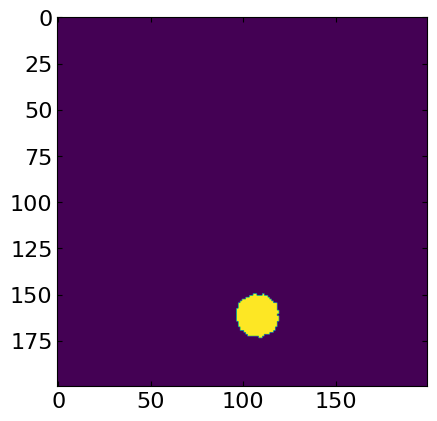

In [93]:
plt.imshow(modified_mask_list_2[0])

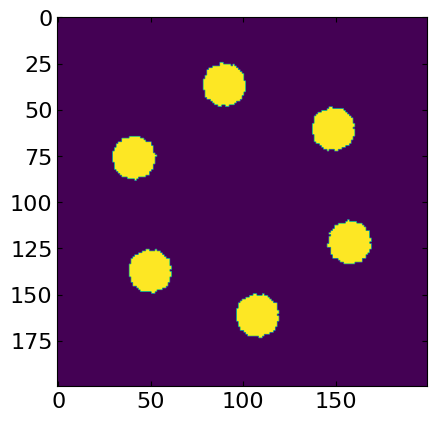

In [94]:
plt.imshow(rotate_mask_up)

# Set new circle with small radius

## Generate base and recorrect the mask region and decrease the mask region

In [95]:
def upsample_mask(mask_list,input_size, up_size):
    
    if mask_list[0].shape[-1]==up_size:
        return mask_list
    
    mask_with_inp = []
    for mask_ in mask_list:
        temp_mask = torch.tensor(mask_.reshape(1,1,input_size,input_size),dtype=torch.float)
        temp_mask = F.interpolate(temp_mask, size=(up_size,up_size),mode = 'bicubic')
        temp_mask[temp_mask<0.5]=0
        temp_mask[temp_mask>=0.5]=1
        temp_mask = torch.tensor(temp_mask.squeeze(),dtype=torch.bool)
        mask_with_inp.append(temp_mask)

    return mask_with_inp

In [51]:
def center_mask_list_function(image,mask_list,coef,radius=7):
    
    center_mask_list = []
    mean_ = np.zeros([image.shape[-2],image.shape[-1]])
    
    input_size = mask_list[0].shape[-1]
    up_size = image.shape[-1]
    
    if input_size!=up_size:
        
        mask_list = upsample_mask(mask_list,input_size,up_size)
    
    for j, mask in enumerate(mask_list):
        

        mask_ = mask.reshape(1,1,mask.shape[-2],mask.shape[-1])

        new_image = image*mask_

        center_x,center_y = center_of_mass(new_image.squeeze(),mask_.squeeze(),coef)
        
        center_x = int(np.round(np.array(center_x)))
        center_y = int(np.round(np.array(center_y)))
        print(center_x,center_y)
        
        small_mask = mask_function(mean_,radius=radius,center_coordinates=(center_y,center_x))
        
        small_mask = torch.tensor(small_mask,dtype = torch.bool)
        
        center_mask_list.append(small_mask)
        
    if input_size!=up_size:
        
        center_mask_list = upsample_mask(center_mask_list,up_size,input_size)
        
    rotate_mask_up = torch.clone(center_mask_list[0])
    
    for i in range(1,len(center_mask_list)):
        rotate_mask_up+=center_mask_list[i]
        
    return center_mask_list,rotate_mask_up

## Parameters for second Training Process

In [52]:
num_mask_2 = 6
fixed_mask_2 = modified_mask_list_2
interpolate_2 = True

## Model for second process training

In [53]:
def make_model_2(device,
               en_original_step_size = en_original_step_size, 
               pool_list = pool_list, 
               de_original_step_size = de_original_step_size,
               up_list = up_list,
               embedding_size = embedding_size,
               conv_size = conv_size,
               num_basis = num_basis,
               num_mask = num_mask_2,
               fixed_mask = fixed_mask_2,
               learning_rate = 3e-5,
               interpolate = interpolate_2,
               up_size = up_size
               ):
    
    encoder = Encoder(original_step_size=en_original_step_size,
                      pool_list=pool_list,
                      embedding_size=embedding_size,
                      conv_size=conv_size,
                      device = device,
                      num_basis=num_basis,
                      fixed_mask = fixed_mask,
                      num_mask=num_mask,
                      interpolate = interpolate,
                      up_size = up_size).to(device)
    decoder = Decoder(original_step_size=de_original_step_size,
                      up_list=up_list,
                      embedding_size=embedding_size,
                      conv_size=conv_size,
                      device = device,
                      num_basis=num_basis).to(device)
    join = Joint(encoder,decoder,device).to(device)
    
    optimizer = optim.Adam(join.parameters(), lr=learning_rate)
    
    join = torch.nn.parallel.DataParallel(join)
    
    return encoder, decoder, join, optimizer

# Loss Function for Second Process
## loss function used for small batch size

In [62]:
def loss_function_2nd(join,
                      train_iterator,
                      optimizer,
                      device,
                      coef1 = 0,
                      coef2 = 0,
                      coef3 = 0,
                      ln_parm = 1, 
                      mask_ = None,
                      up_inp = False
                     ):

    weight_decay = coef1
    scale_coef = coef2
    shear_coef = coef3

    # set the train mode
    join.eval()

    # loss of the epoch
    train_loss = 0
    L2_loss = 0 
    Scale_Loss = 0
    Shear_Loss = 0 
    with torch.no_grad():
        for x,y in tqdm(train_iterator, leave=True, total=len(train_iterator)):
         
    
            x = x.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.float)
    
            
            if up_inp:
                
                predicted_x,predicted_base,predicted_input,kout,theta_1,theta_2,adj_mask,new_list,x_inp = join(x,y)
                
    #             print(mask_[0].shape)
    #             print(x.shape[-1])
    #             print(x_inp.shape[-1])
                
                mask_ = upsample_mask(mask_,x.shape[-1], x_inp.shape[-1])
                
            else:
                predicted_x,predicted_base,predicted_input,kout,theta_1,theta_2,adj_mask,new_list= join(x,y)
            
    
            l2_loss = weight_decay*torch.norm(predicted_base.squeeze(), p=ln_parm)/x.shape[0]
            scale_loss = scale_coef*(torch.mean(F.relu(abs(theta_1[:,0,0]-1)-0.04))\
                                     +torch.mean(F.relu(abs(theta_1[:,1,1]-1)-0.04)))
            shear_loss = shear_coef*torch.mean(F.relu(abs(theta_1[:,0,1])-0.04)) 
            
            loss  = (l2_loss + scale_loss + shear_loss)*len(mask_)
    
            for i,mask in enumerate(mask_):
    
                
                loss += F.mse_loss(predicted_base.squeeze()[:,mask], predicted_x.squeeze()[:,mask], reduction='mean')
                #set the loss for the generated input and input
                sub_loss = 0
                for k in range(x.shape[0]):
                    
                    if up_inp:
                        sub_loss += F.mse_loss(predicted_input[k].squeeze()[new_list[i][k]], x_inp[k].squeeze()[new_list[i][k]], reduction='mean')
                    else:
                        sub_loss += F.mse_loss(predicted_input[k].squeeze()[new_list[i][k]], x[k].squeeze()[new_list[i][k]], reduction='mean')
    
                loss += (sub_loss/x.shape[0])
    
            loss = loss/(len(mask_)*15)
    
            if loss>1.5:
                loss  =  (l2_loss + scale_loss + shear_loss)*len(mask_)
                for i,mask in enumerate(mask_):
    
                    loss += F.l1_loss(predicted_base.squeeze()[:,mask], predicted_x.squeeze()[:,mask], reduction='mean')
    
                    sub_loss = 0
                    for k in range(x.shape[0]):
    
                        if up_inp:
                            sub_loss += F.l1_loss(predicted_input[k].squeeze()[new_list[i][k]], x_inp[k].squeeze()[new_list[i][k]], reduction='mean')
                        else:
                            sub_loss += F.l1_loss(predicted_input[k].squeeze()[new_list[i][k]], x[k].squeeze()[new_list[i][k]], reduction='mean')
                    loss += (sub_loss/x.shape[0])
    
                loss = loss/(len(mask_)*15)
                loss = loss- 1
    
            if loss>(2*len(mask_)):
                loss=2*len(mask_)+l2_loss + scale_loss + shear_loss
    
                    
            # backward pass
            train_loss += loss.item()
            L2_loss += l2_loss
            Scale_Loss += scale_loss
            Shear_Loss += shear_loss


    return train_loss, L2_loss, Scale_Loss, Shear_Loss

## loss function used for large batch size

## Validate Loss fuction

In [55]:
# def validate_loss(join,
#                   validate_iterator,
#                   device,
#                   mask_,
#                   up_inp
#                  ):


#     # set the evaluate mode
#     join.eval()

#     # loss of the epoch
#     validate_l = 0
    
#     for x,y in tqdm(validate_iterator, leave=True, total=len(validate_iterator)):
        
#         with torch.no_grad():
     

#             x = x.to(device, dtype=torch.float)
#             y = y.to(device, dtype=torch.float)
            
#             if up_inp:

#                 predicted_x,predicted_base,predicted_input,kout,theta_1,theta_2,adj_mask,new_list,x_inp = join(x,y)

#                 mask_ = upsample_mask(mask_,x.shape[-1], x_inp.shape[-1])

#             else:
#                 predicted_x,predicted_base,predicted_input,kout,theta_1,theta_2,adj_mask,new_list= join(x,y)

#             loss = 0

#             for i,mask in enumerate(mask_):


#                 loss += F.mse_loss(predicted_base.squeeze()[:,mask], predicted_x.squeeze()[:,mask], reduction='mean')
#                 #set the loss for the generated input and input
#                 sub_loss = 0
#                 for k in range(x.shape[0]):
                    
#                     if up_inp:

#                         sub_loss += F.mse_loss(predicted_input[k].squeeze()[new_list[i][k]], x_inp[k].squeeze()[new_list[i][k]], reduction='mean')
#                     else:
                        
#                         sub_loss += F.mse_loss(predicted_input[k].squeeze()[new_list[i][k]], x[k].squeeze()[new_list[i][k]], reduction='mean')
                        
#                 loss += (sub_loss/x.shape[0])

#             loss = loss/(len(mask_)*30)


#             validate_l += loss.item()
        
#     validate_l = validate_l/len(validate_iterator)

#     return validate_l

# Set function for performance monitor

## Polar Decomposition 

In [56]:
# Define function of exx, eyy and exy
def basis2probe(rotation_,scale_shear_):
    
    M = []
    #    G_ref_inv = np.linalg.inv(G_ref)
    for i in tqdm(range(65536),leave=True,total=65536):
        
        theta = np.arctan2(rotation_[i][1], rotation_[i][0]) 
                       
        xx = scale_shear_[i][0]
        yy = scale_shear_[i][3]
        
        xy = scale_shear_[i][1]
        yx = scale_shear_[i][2]
        
        
        r = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
            ])
        t = np.array([
            [xx,xy],
            [yx,yy]
            ])
        m = np.linalg.inv(t) @ np.linalg.inv(r)

        # t1 = np.array([
        #     [xx,0],
        #     [0,yy]
        #     ])
        # t2 = np.array([
        #     [1,xy],
        #     [yx,1]
        #     ])
        # m = r @ np.linalg.inv(t1) @ np.linalg.inv(t2)
        
        M.append(m)
        
    M  = np.array(M)
    return M

## The function for the scale and shear evaluation

In [57]:
def Show_Process(model,test_iterator,mask_list,name_of_file,device,up_inp):

    model.eval()
    
    rotation_ = np.zeros([65536,2])
    scale_shear_ = np.zeros([65536,4])
    number_loss = len(mask_list)
    loss_map = np.zeros([65536,number_loss])

    for i, x in enumerate(tqdm(test_iterator,leave=True,total=len(test_iterator))):
        with torch.no_grad():
            value,rot = x
            rot = Variable(rot.cuda()).float()
            test_value = Variable(value.cuda())
            test_value = test_value.float()
            
            if up_inp:
                predicted_x,predicted_base,predicted_input,kout,theta_1,theta_2,adj_mask,new_list,x_inp= model(test_value.to(device, dtype=torch.float),
                                                                                                               rot.to(device, dtype=torch.float))
                
                mask_list = upsample_mask(mask_list,test_value.shape[-1], x_inp.shape[-1])
                
            else:
                predicted_x,predicted_base,predicted_input,kout,theta_1,theta_2,adj_mask,new_list= model(test_value.to(device, dtype=torch.float),
                                                                                                         rot.to(device, dtype=torch.float))
            
            batch_size = test_value.shape[0]
            
            rotation_[i*batch_size:(i+1)*batch_size] = theta_2[:,:,0].cpu().detach().numpy()

            scale_shear_[i*batch_size:(i+1)*batch_size] = theta_1[:,:,0:2].cpu().detach().numpy().reshape(-1,4)
            
            
            for j,mask in enumerate(mask_list):
                
                temp_loss = 0

                temp_loss += torch.mean((predicted_base.squeeze()[:,mask] - predicted_x.squeeze()[:,mask])**2,1)

                for k in range(test_value.shape[0]):
                    if up_inp:
                        single_loss = F.mse_loss(predicted_input[k].squeeze()[new_list[j][k]], x_inp[k].squeeze()[new_list[j][k]], reduction='mean')
                    else:
                        single_loss = F.mse_loss(predicted_input[k].squeeze()[new_list[j][k]], test_value[k].squeeze()[new_list[j][k]], reduction='mean')
                    temp_loss[k] +=single_loss

      
                loss_map[i*batch_size:(i+1)*batch_size,j] = temp_loss.cpu().detach().numpy().reshape(batch_size)
        
    loss_map = np.mean(loss_map,axis=1)      
        
            
    predicted_base = predicted_base[0].cpu().detach().numpy()
    
    h5f = h5py.File(name_of_file+'.h5', 'w')
    h5f.create_dataset('rotation', data=rotation_)
    h5f.create_dataset('scale_shear', data=scale_shear_)
    h5f.create_dataset('loss', data=loss_map)
    h5f.create_dataset('base', data=predicted_base)
    
    # stack the list to torch tensor for saving in the h5 format
    gou_list  = torch.cat(mask_list)
    gou_list = gou_list.reshape(len(mask_list),mask_list[0].shape[-2],mask_list[0].shape[-1])
    
    h5f.create_dataset('mask_list', data=gou_list)
    h5f.close()
    
    im_size = (256,256)
    M_init = basis2probe(rotation_,scale_shear_).reshape(im_size[0],im_size[1],2,2)
    
    M_ref = np.median(M_init[30:60,10:40],axis=(0,1))

    # u_ref, p_ref = sp.linalg.polar(M_ref, side='right')


    exx_Shuyu = np.zeros((im_size[0],im_size[1]))
    eyy_Shuyu = np.zeros((im_size[0],im_size[1]))
    exy_Shuyu = np.zeros((im_size[0],im_size[1]))

    for rx in range(im_size[0]):
        for ry in range(im_size[1]):

            T = M_init[rx,ry] @ np.linalg.inv(M_ref)
            u, p = sp.linalg.polar(T, side='left')

            transformation = np.array([
                [p[0,0] - 1, p[0,1]],
                [p[0,1], p[1,1] - 1],
            ])

     #       transformation = u @ transformation @ u.T

            exx_Shuyu[rx,ry] = transformation[1,1]
            eyy_Shuyu[rx,ry] = transformation[0,0]
            exy_Shuyu[rx,ry] = transformation[0,1]    
        
    return exx_Shuyu,eyy_Shuyu,exy_Shuyu

In [58]:
def Generate_scale_shear_loss(exx_Shuyu,eyy_Shuyu,exy_Shuyu,label_xx,label_yy,label_xy):
    dif_shuyu_xx = exx_Shuyu - label_xx
    dif_shuyu_yy = eyy_Shuyu - label_yy
    dif_shuyu_xy = exy_Shuyu - label_xy
    mae_shuyu_xx = np.mean(abs(dif_shuyu_xx)) 
    mae_shuyu_yy = np.mean(abs(dif_shuyu_yy)) 
    mae_shuyu_xy = np.mean(abs(dif_shuyu_xy)) 
    
    combine_loss = mae_shuyu_xx + mae_shuyu_yy + mae_shuyu_xy
    
    return combine_loss

# Second training process
### set training parameters

In [97]:
data_dir = os.path.abspath("./Extremely_Noisy_4DSTEM_Strain_Mapping_Using_CC_ST_AE_Simulated/polycrystal_output4D.mat")
#folder_path = os.path.abspath("./07_13_25Percent_Upsample_SCALE_SHEAR_On_MASK_Test_large_MASK_update_MASK_once_15DEGREE")
#pretrain_weight = os.path.abspath("./04_20_RAYTUNE_lr:0.000065_scale_cof:80.350_shear_cof:16.100_MAE:0.0063_seed:42_epoch:0004_trainloss:0.002384_l1:0.00014_scal:0.00000_shr:0.00000.pkl")

In [99]:
whole_data_with_rotation = load_data_4_process2(data_dir,new_rotation,w_bg=0.25)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 65536/65536 [00:00<00:00, 951322.26it/s]


In [107]:
def Test_Process(data_set,
                 epochs=1,
                 activity_regular='l1',
                 mask_= modified_mask_list_2,
                 check_mask = modified_mask_list_2,
                 Up_inp = interpolate_2,
                 epoch_ = None,
                 file_path = None,
                 folder_path='',
                 best_train_loss= None,
                ):
        
            
        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda"
        
        
        seed = 42
        np.random.seed(seed)
        torch.manual_seed(seed)
        print('.........a step.........')

    #        print(config["learning_rate"])

        print('.........b step.........')

        learning_rate = 3e-4
#        max_rate = config["max_rate"]

        coef_1 = 5e-7
        coef_2 = 70
        coef_3 = 10
        batch_para = 64


        learning_rate = int(learning_rate*1e6)/1e6
#        max_rate = int(max_rate*1e6)/1e6
        coef_1 = int(coef_1*1e9)/1e9
        coef_2 = int(coef_2*1e2)/1e2
        coef_3 = int(coef_3*1e2)/1e2
        
        patience = 0
        
        print("........successfully load parameters")
        
        encoder, decoder, join, optimizer = \
        make_model_2(device,learning_rate = learning_rate,fixed_mask = mask_)

        checkpoint = '2nd_train_weight_25Per.pkl'
        pre_weight = torch.load(checkpoint)
        join.load_state_dict(pre_weight["net"])
        
        if activity_regular == 'l1':
            regul_type = 1
            
        elif activity_regular == 'l2':
            regul_type = 2
            
        else:
            regul_type = 0
            
     
        print('..........successfully generate model')
        
        
        train_iterator = DataLoader(data_set, batch_size=64, shuffle=False, num_workers=0)

        N_EPOCHS = epochs

        if best_train_loss == None:
            best_train_loss = float('inf')


        if epoch_==None:
            start_epoch = 0
        else:
            start_epoch = epoch_+1
        print('...........successfully generate train interator')

        for epoch in range(start_epoch,epochs):
    #    This loss function include the entropy loss with increasing coefficient value
        
    
            train = loss_function_2nd(join,train_iterator,
                                  optimizer,device,coef_1,coef_2,coef_3,regul_type,mask_,interpolate_2)

            input_length = len(train_iterator)
                
                
            train_loss,L2_loss,Scale_Loss, Shear_Loss = train
            
            train_loss /= input_length
            L2_loss /= input_length
            Scale_Loss /= input_length
            Shear_Loss /= input_length

    #        VAE_L /= len(train_iterator)
            print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}')
    #        print(f'......... VAE Loss: {VAE_L:.4f}')
            print('.............................')



In [109]:
Test_Process(whole_data_with_rotation)

.........a step.........
.........b step.........
........successfully load parameters
..........successfully generate model
...........successfully generate train interator


  0%|▏                                                                                                               | 2/1024 [00:17<2:30:10,  8.82s/it]


KeyboardInterrupt: 